In [4]:
%matplotlib inline
import numpy as np
from numpy import*
import matplotlib.pyplot as plt

from scipy import interpolate

from scipy.special import factorial
from scipy import fftpack
from skimage import io
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy import signal
import scipy.ndimage as nd
from IPython.display import display, Markdown, Latex

import glob

In [13]:
def imread(img_filename):
    img = io.imread(img_filename, as_grey=True)

    img = (255*((img - np.min(img))/(np.max(img)-np.min(img)))).astype(np.uint8)
    
    return img

def get_gauss(
        A,
        factor_x,
        factor_y,
        sigma_0,
        dt,
        x,
        y,
        theta,
    ):
    sigma_x = sigma_0*factor_x
    sigma_y = sigma_0*factor_y


    a = ((cos(theta)**2) / (2*sigma_x**2)) + ((sin(theta)**2) / (2*sigma_y**2))


    b = -((sin(2*theta)) / (4*sigma_x**2)) + ((sin(2*theta)) / (4*sigma_y**2))
    c = ((sin(theta)**2) / (2*sigma_x**2)) + ((cos(theta)**2) / (2*sigma_y**2))


    g = A*exp(-a*(x-dt)**2 - 2*b*(x-dt)*(y-dt) - c*(y-dt)**2)
    return g

def get_log(
        factor_x,
        factor_y,
        sigma,
        x,
        y,
        theta,
    ):

    xr = x*cos(theta) - y*sin(theta)
    yr = x*sin(theta) + y*cos(theta)
    fac = -(xr**2./factor_x + yr**2./factor_y)/(2.*sigma**2)
    log  = -(1+fac)*exp(fac)/(pi*sigma**4.)

   
    return log

# Projeto I

## Descrição
## Objetivos

- Criar um fitlro gaussiano usando convolução e transformada de Fourrier

## Parâmetros

## Distribuição Gaussiana

A variável gauss contem os pontos da distribuição gaussiana dentro dos limites, "bounds" 

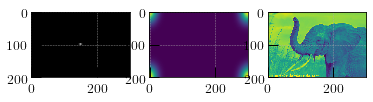

In [6]:
# First a 1-D  Gaussian

img_filename="elephant.png"





img = imread(img_filename)
#img = img[0:n_points_y, 0:n_points_x]

n_points_x=img.shape[1]
n_points_y=img.shape[0]

factor = 1
sigma = 2
theta = 0.

A = 1/sqrt(2.*pi*sigma)
xs = linspace(-img.shape[0]/2, img.shape[0]/2, n_points_x)
ys = linspace(-img.shape[1]/2, img.shape[1]/2, n_points_y)

X, Y = np.meshgrid(xs, ys)

gauss = get_gauss(A, factor, factor, sigma, 0, X[:], Y[:], theta)

gauss_shift = fftpack.fftshift( gauss)

kernel_ft = fftpack.fft2(gauss_shift)

img_shift = fftpack.fftshift(img)

fig, ax = plt.subplots(1, 3)

ax[0].imshow(gauss, cmap="gray")


ax[1].imshow(kernel_ft.real)
ax[2].imshow( img)

#cbar = plt.colorbar(countour)

plt.show()

Agora aplicamos a transformada de fourrier no núcleo gaussiano tendo uma tamanho de janela igual a dimensão da imagem original

In [7]:

# convolve
img_shift_ft = fftpack.fft2(img_shift)
#img_ft = fftpack.fftshift( img_ft )
img2_shift_ft = kernel_ft[:, :] * img_shift_ft

#aplica a inversa da transformada
img2_shift = fftpack.ifft2(img2_shift_ft).real
img2 = fftpack.fftshift(img2_shift)

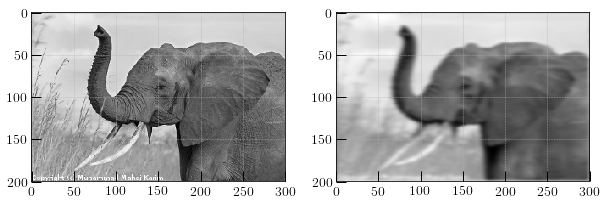

In [8]:


# the 'newaxis' is to match to color direction



# clip values to range
#img2 = np.clip(img2, 0, 1)

# plot output
fig, ax = plt.subplots(1, 2, figsize=(10, 20))
ax[0].imshow(img, cmap="gray")
ax[1].imshow(img2, cmap = "gray")
plt.show()

# Projeto II e III

## Descrição
## Objetivos

- Criar um fitlro gaussiano usando convolução e transformada de Fourrier

In [9]:
import scipy.ndimage as nd




def apply_log_scipy(img, sigma=2):
    log = nd.gaussian_laplace(img, sigma)
    return log


def apply_bin(img, neighs):
    img[np.where(img <= 0.0)] = -1
    img[np.where(img > 0.0)] = 1
    new_img = zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            val = img[i, j]
            vals_neigh = []
            for dx, dy in neighs:
                try:
                    vals_neigh.append(img[i+dx, j+dy])
                except:
                    pass
            borda = any([val*n <0 for n in vals_neigh])
            #borda = len(list(filter(lambda r: r < 0 , [val*n for n in vals_neigh]))) >2
            new_img[i, j] = 1 if borda else 0.
    return new_img


def get_neighs(n_neighs):
    neighs =  [(1, 0), (-1, 0), (0, 1), (0, -1)]
    if n_neighs==8:
         neighs += [(1, 1), (-1, 1), (-1, -1), (1, -1)]
    return neighs

## Projeto II




In [26]:

def apply_DoG(
        img,
        A,
        factor_x=1,
        factor_y=1,
        sigma_0=1,
        dts=[.1, -.1],
        theta=0.,
    ):
    
    img_shift = fftpack.fftshift(img)

    img_ft_shift = fftpack.fft2(img_shift)
    points_x = img.shape[1]
    points_y = img.shape[0]
    xs = linspace(-img.shape[0]/2, img.shape[0]/2, points_x)
    ys = linspace(-img.shape[1]/2, img.shape[1]/2, points_y)

    X, Y = np.meshgrid(xs, ys)

    kernels = [
        get_gauss(A, factor_x, factor_y, sigma_0, dt,X[:], Y[:], theta)
        for  dt in dts
    ]
    
    kernels_shift = [
        fftpack.fftshift( gauss)
        for gauss in kernels
    ]





    DoG_shift = kernels_shift[0]-kernels_shift[1]
    DoG_shift_ft = fftpack.fft2(DoG_shift, shape=img.shape)

    img2_shift_ft = DoG_shift_ft[:, :] * img_ft_shift

   
    img2_shift = fftpack.ifft2(img2_shift_ft, axes=(0, 1)).real
    img2 = fftpack.fftshift(img2_shift)
    
    return img2, X, Y, kernels[0], kernels[1]



def apply_LoG(
        img,
        factor_x=1,
        factor_y=1,
        sigma=1,
        theta=0.,
    ):
    
    img_shift = fftpack.fftshift(img)

    img_ft_shift = fftpack.fft2(img_shift)
    points_x = img.shape[1]
    points_y = img.shape[0]
    xs = linspace(-img.shape[0]/2, img.shape[0]/2, points_x)
    ys = linspace(-img.shape[1]/2, img.shape[1]/2, points_y)

    X, Y = np.meshgrid(xs, ys)
    kernel = get_log(factor_x, factor_y, sigma, X[:], Y[:], theta)
    LoG_shift = fftpack.fftshift(kernel)
       


    
    LoG_shift_ft = fftpack.fft2(LoG_shift, shape=img.shape)

    img2_shift_ft = LoG_shift_ft[:, :] * img_ft_shift

   
    img2_shift = fftpack.ifft2(img2_shift_ft, axes=(0, 1)).real
    img2 = fftpack.fftshift(img2_shift)
    
    return img2, X, Y, kernel

def border_uniform(
        img_filename="casa1.png",
        A=1,
        factor=1,
        sigma_0=1,
        dt=.1,
        n_neighs = 4,
        theta=0.,
        DoG=True
    ):
   
    img0 = imread(img_filename)


    neighs = get_neighs(n_neighs)
    if DoG:
        img2, X, Y, gauss_1, gauss_2 = apply_DoG(
            img0.copy(),
            A,
            factor,
            factor,
            sigma_0,
            [dt, -dt],
            0.
        )
    else:
        img2, X, Y, LoG = apply_LoG(
            img0.copy(),
            factor,
            factor,
            sigma_0,
            0.
        )
    #img2 = (img2 > threshold).astype(np.int_)
    #img2 = (img2- np.mean(img2))/np.std(img2)

    img3 = apply_bin(img2.copy(), neighs)

    fig, ax = plt.subplots(1,4, figsize=(20, 5))
    if DoG:
        ax[0].imshow(gauss_1)
    else:
        ax[0].imshow(LoG)

    #ax[1].imshow(gauss_2)


    ax[1].imshow(img0, cmap="gray")
    

    ax[2].imshow(img2, cmap="gray")
    ax[3].imshow(img3, cmap="gray")

    plt.show()




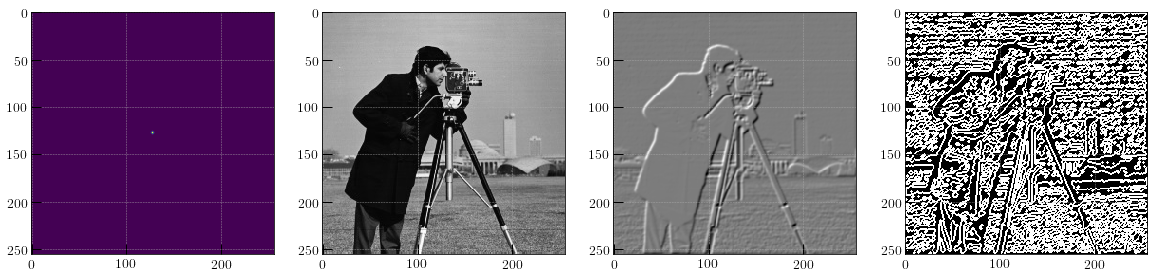

In [27]:
A=1
factor=1
sigma_0=1
border_uniform(
    img_filename="fotografo.png",
    factor = factor,
    sigma_0 = sigma_0
)

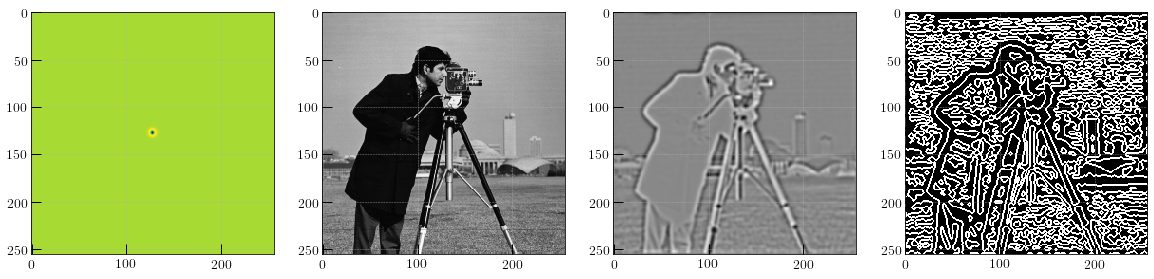

In [19]:

factor=1
sigma_0=2.
border_uniform(
    img_filename="fotografo.png",
    factor = factor,
    sigma_0 = sigma_0,
    DoG=False
)

In [59]:
interactive_plot = interactive(
                                border_uniform,
                                img_filename=glob.glob('*.png'),
                                A=(0.01,2, .001),
                                factor=(.5, 5, .1),
                                sigma_0=(0.1, 5, .1),
                                dt=(0.001, .01, .001),
                                n_neighs = [4, 8]  
                              )

        
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(Dropdown(description='img_filename', options=('casa1.png', 'elephant.png', 'fotografo.pn…

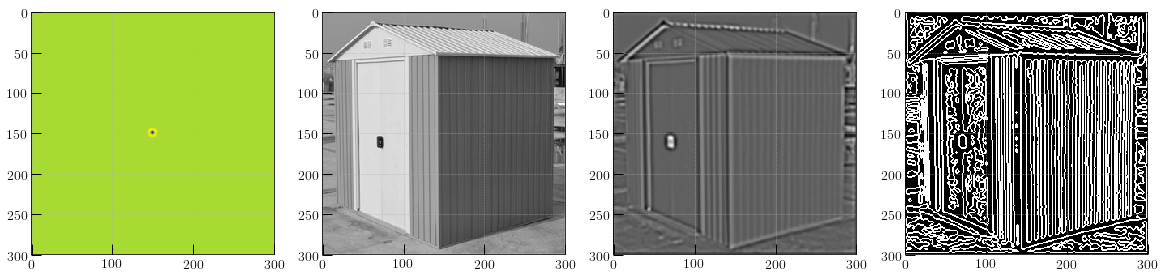

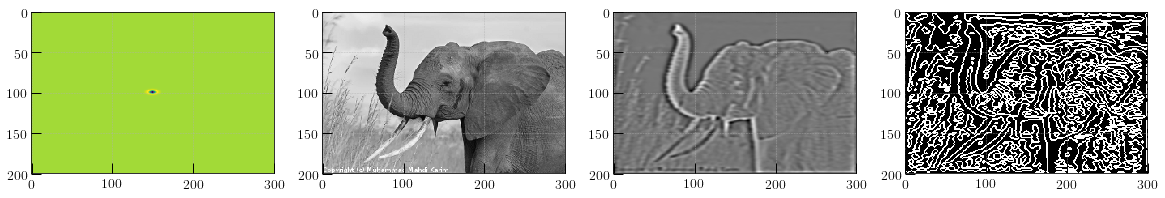

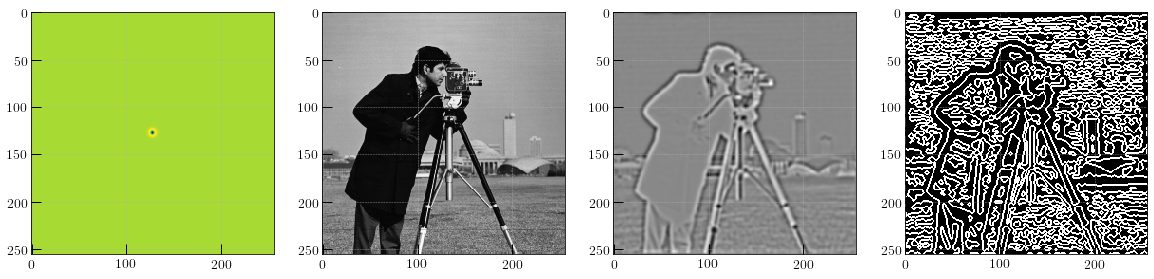

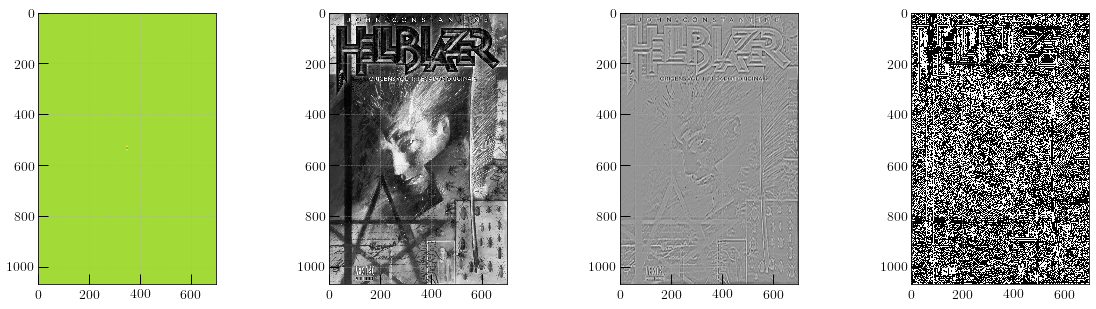

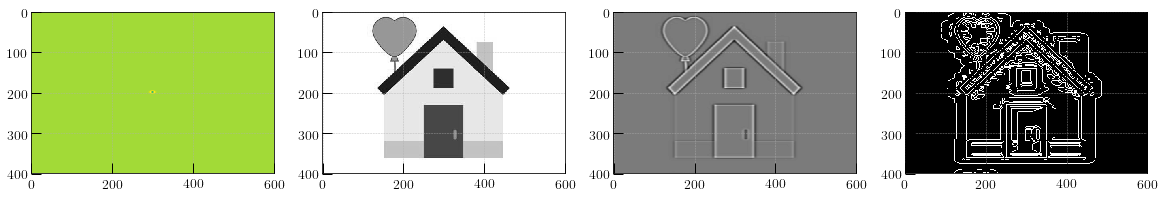

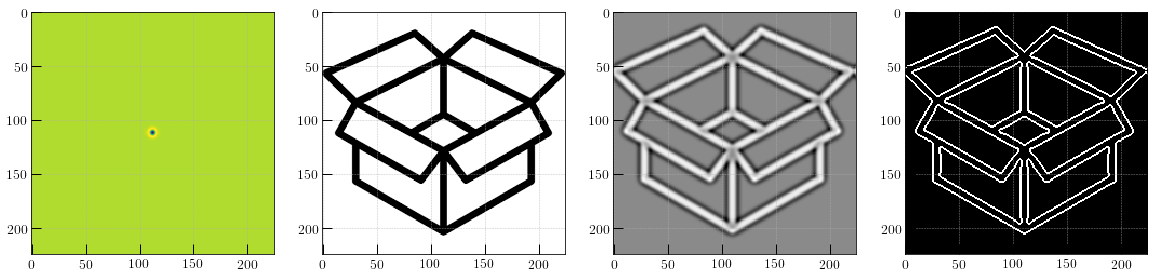

In [62]:
factor=1
sigma_0=2.
for img_filename in glob.glob('*.png'):
    border_uniform(
        img_filename=img_filename,
        factor = factor,
        sigma_0 = sigma_0,
        DoG=False
    )

## Projeto III

In [29]:
def border_theta(
        img_filename="casa1.png",
        A=1,
        factor_x=1,
        factor_y=1,
        sigma_0=1,
        dt=.1,
        theta=0.,
        n_neighs = 4,
        DoG = True
    ):
   
    img0 = imread(img_filename)


    neighs = get_neighs(n_neighs)
    if DoG:
        img2, X, Y, gauss_1, gauss_2 = apply_DoG(
            img0.copy(),
            A,
            factor_x,
            factor_y,
            sigma_0,
            [dt, -dt],
            theta
        )
    else:
        img2, X, Y, gauss_1 = apply_LoG(
            img0.copy(),
            factor_x,
            factor_y,
            sigma_0,
            theta
        )
   
    #img2 = (img2 > threshold).astype(np.int_)
    #img2 = (img2- np.mean(img2))/np.std(img2)

    img3 = apply_bin(img2.copy(), neighs)

    fig, ax = plt.subplots(1,4, figsize=(20, 5))
    ax[0].imshow(gauss_1)
    #ax[1].imshow(gauss_2)


    ax[1].imshow(img0, cmap="gray")
    

    ax[2].imshow(img2, cmap="gray")
    ax[3].imshow(img3, cmap="gray")

    plt.show()


### Plot iterativo

In [67]:
interactive_plot = interactive(
                                border_theta,
                                img_filename=glob.glob('*.png'),
                                A=(0.01,2, .001),
                                factor_x=(.5, 20, .1),
                                factor_y=(.5, 20, .1),
                                sigma_0=(0.5, 10, .1),
                                dt=(0.001, .01, .001),
                                theta =(0, 2*pi, 0.1 ),
                                n_neighs = [4, 8]  
                              )

        
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(Dropdown(description='img_filename', options=('casa1.png', 'elephant.png', 'fotografo.pn…

### Casa

#### DoG

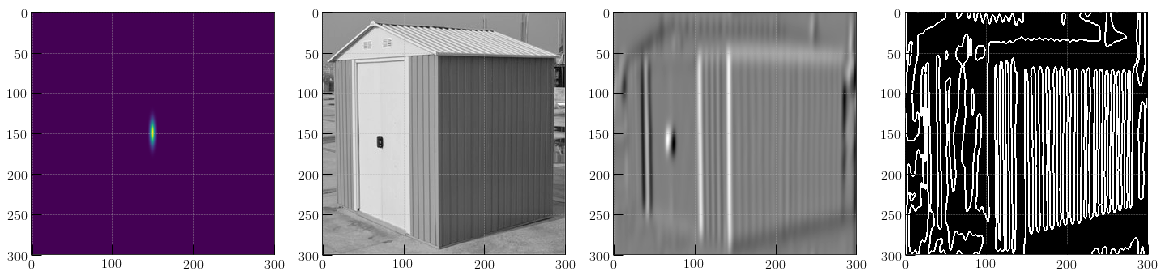

In [48]:
A=1

theta = pi
factor_x=1
factor_y =5
sigma_0=2.
border_theta(
    #img_filename = img_filename,
    factor_x=factor_x, 
    factor_y=factor_y, 
    theta=theta,
    sigma_0 = sigma_0,
    DoG =  True
)

#### LoG

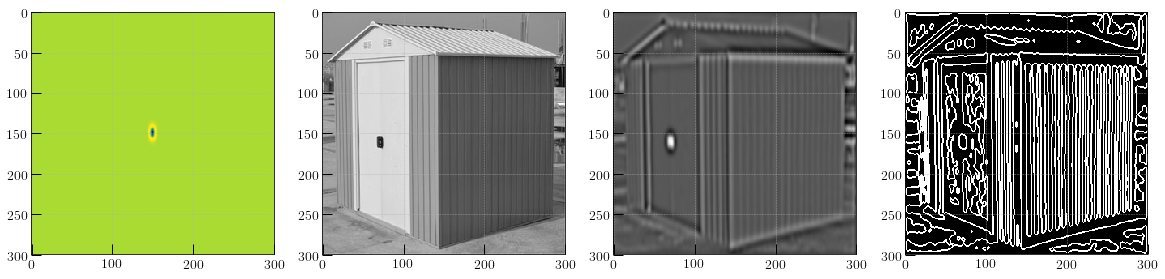

In [50]:

theta = pi
factor_x=1
factor_y =5
sigma_0=2.
border_theta(
    factor_x=factor_x, 
    factor_y=factor_y, 
    theta=theta,
    sigma_0 = sigma_0,
    DoG =  False
)


### Para vários $\theta$

## 0*pi/4.

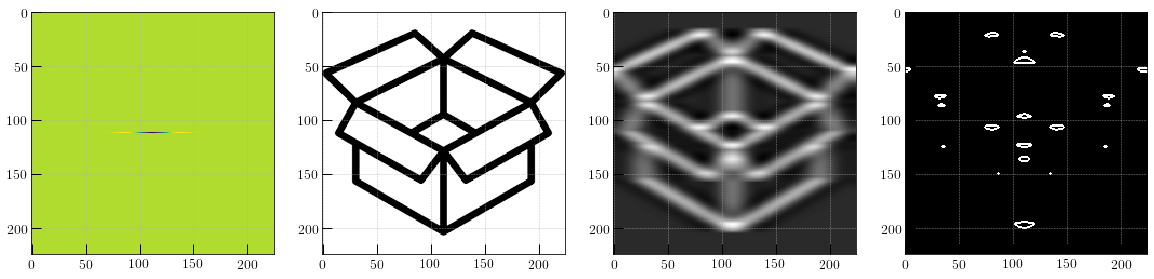

## 1*pi/4.

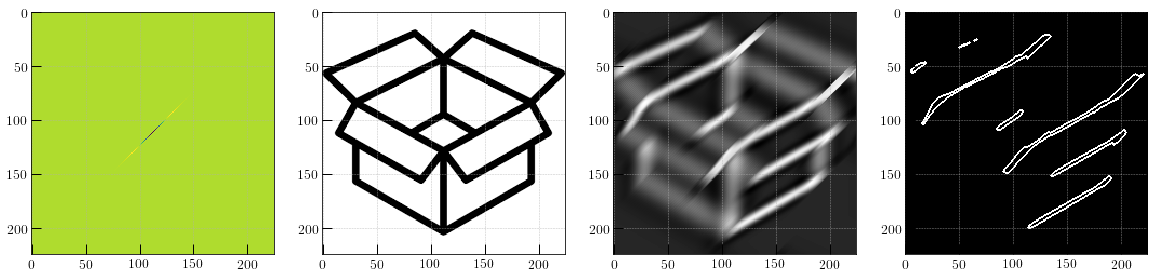

## 2*pi/4.

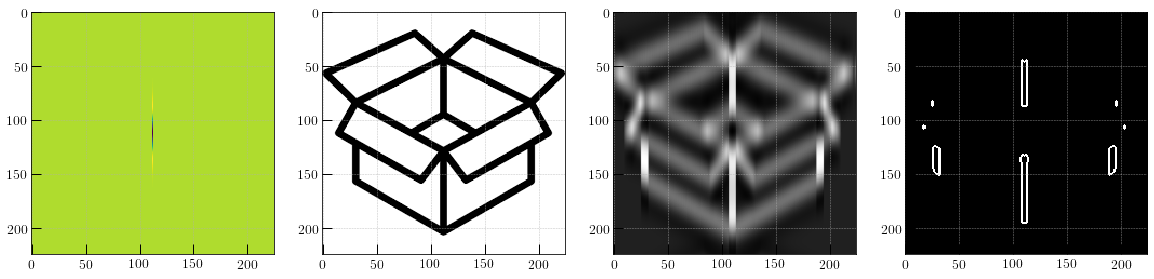

## 3*pi/4.

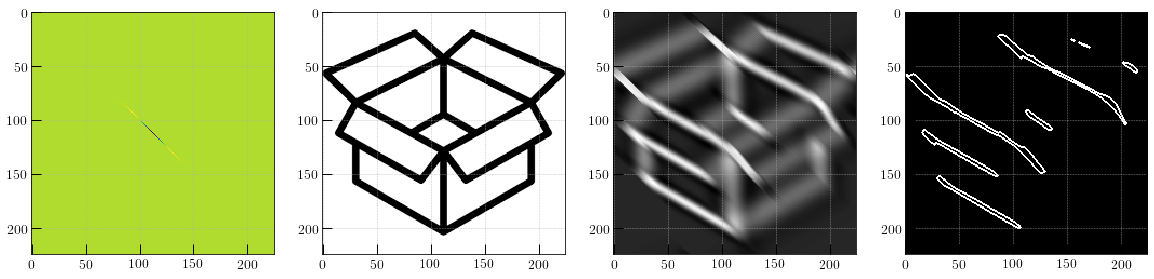

## 4*pi/4.

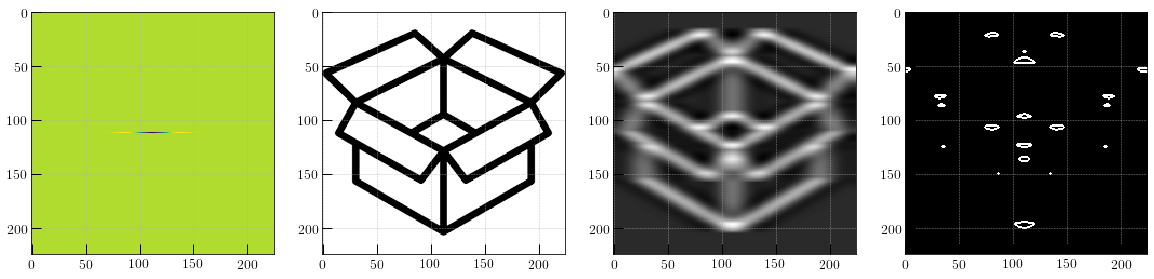

## 5*pi/4.

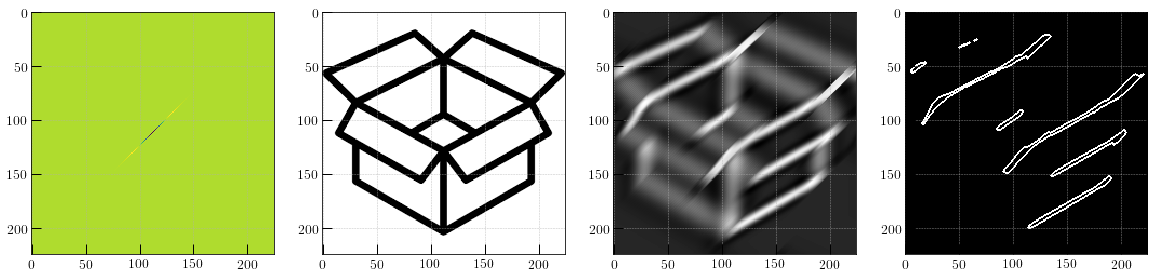

## 6*pi/4.

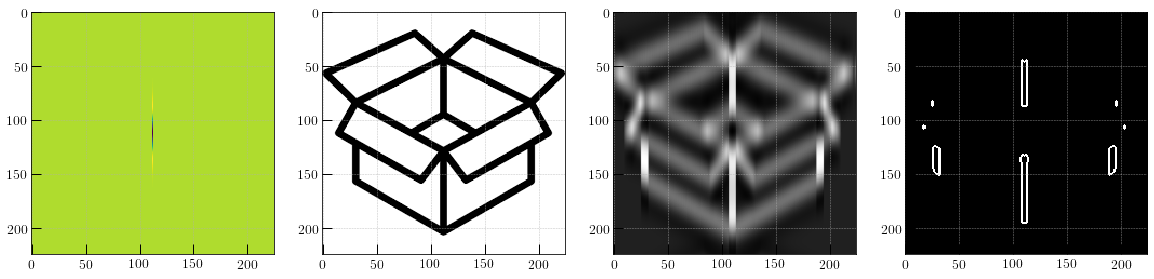

## 7*pi/4.

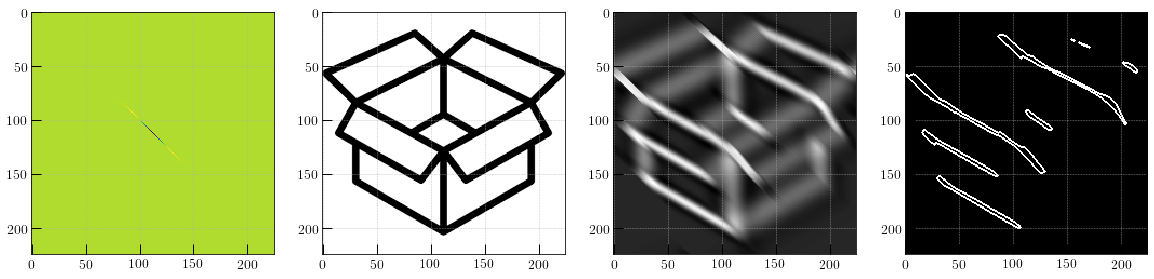

In [108]:
t = "pi/4."
thetas_str = [ "%d*%s"%(i, t) for i in range(0, 8)]


factor_x=40
factor_y =.01
sigma_0=2
for theta_str in thetas_str:
    display(Markdown('## %s'%theta_str))
    exec("theta = %s"%theta_str)
    border_theta(
        img_filename="simple_box.png",
        factor_x=factor_x, 
        factor_y=factor_y, 
        theta=theta,
        sigma_0 = sigma_0,
        DoG =  False
    )


### 6 imagens

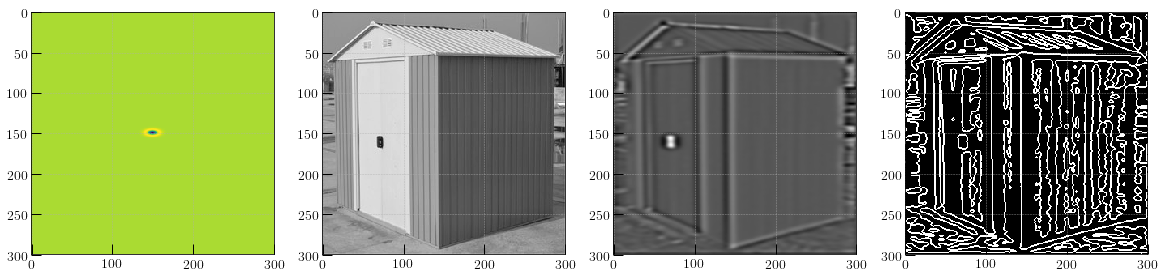

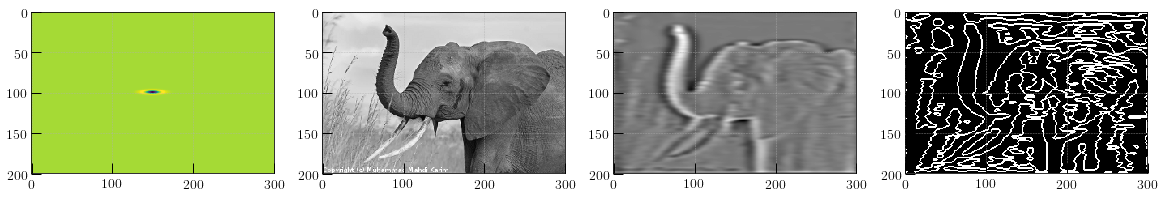

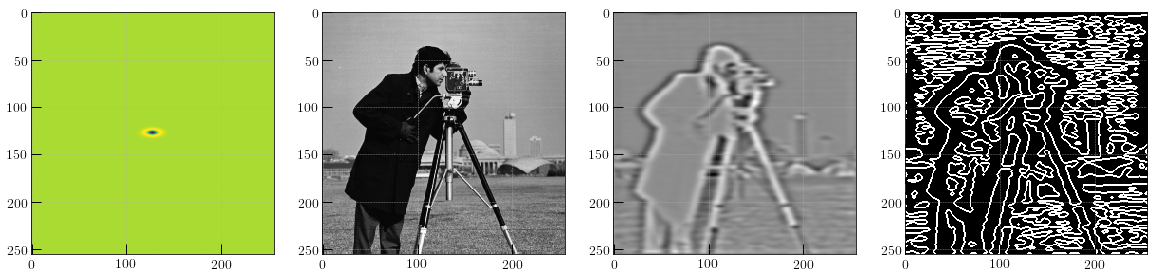

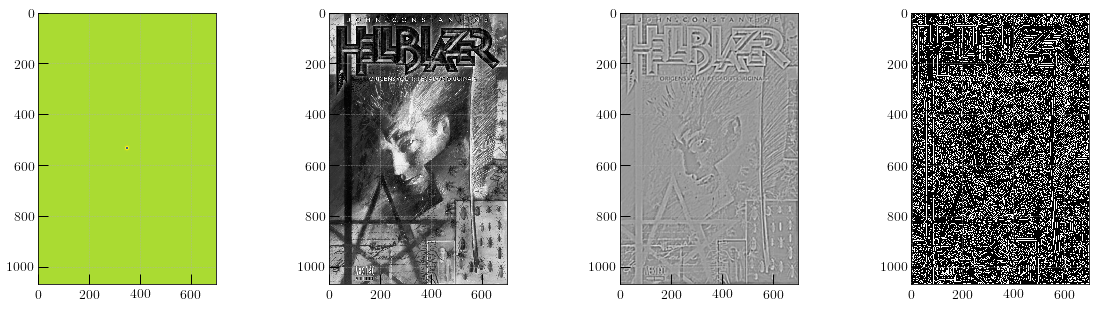

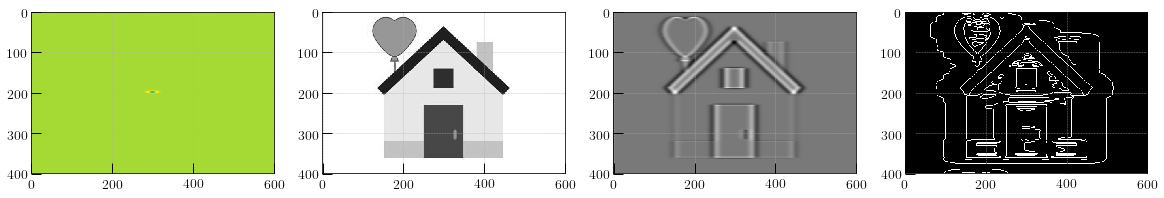

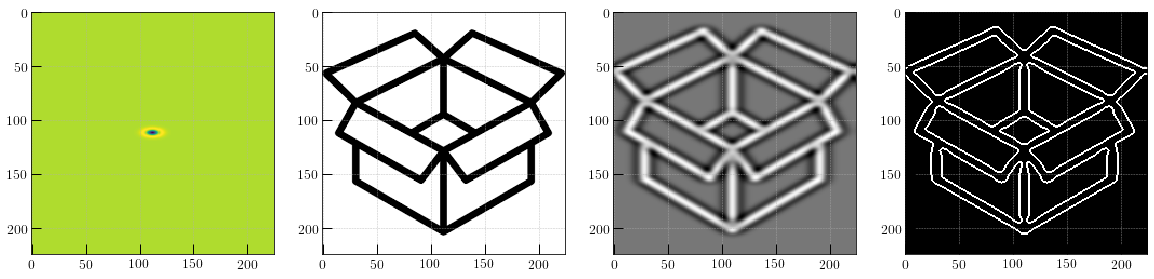

In [63]:
theta = pi/2.
factor_x=1
factor_y =5
sigma_0=2.
for img_filename in glob.glob('*.png'):
    border_theta(
        img_filename=img_filename,
        factor_x=factor_x, 
        factor_y=factor_y, 
        theta=theta,
        sigma_0 = sigma_0,
        DoG =  False
    )

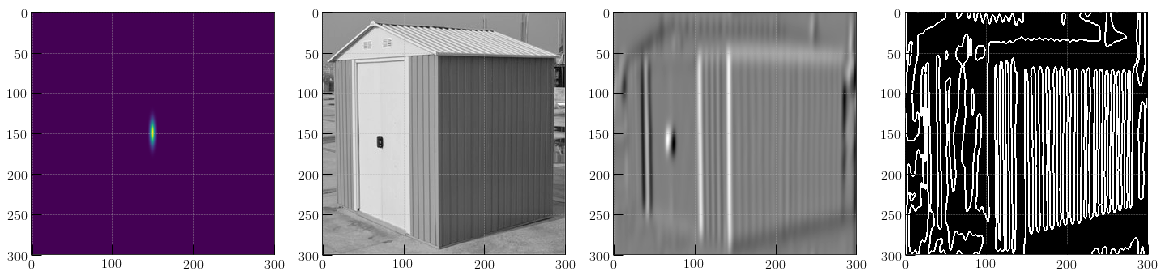

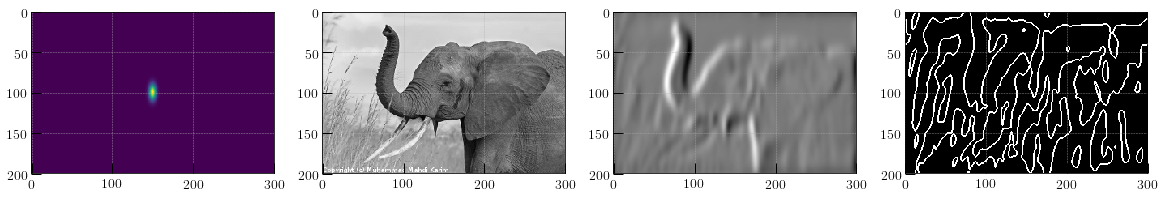

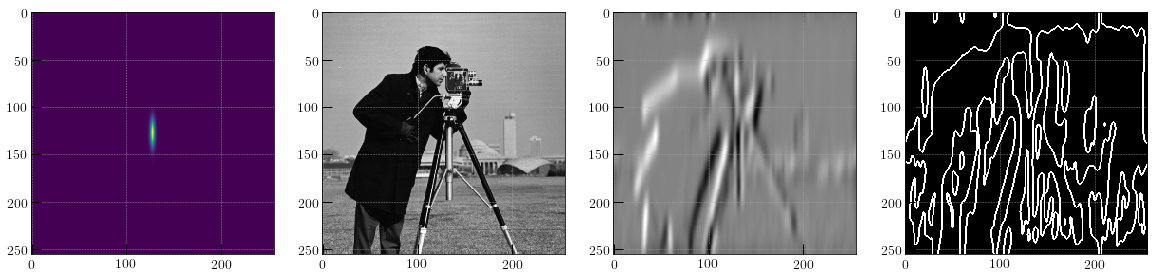

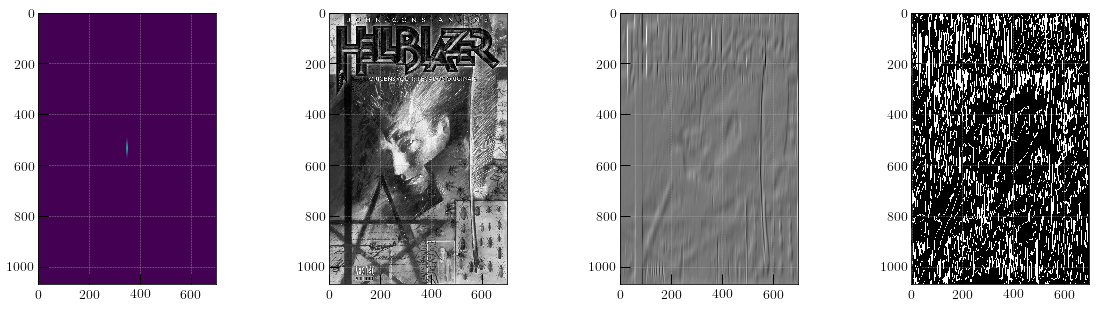

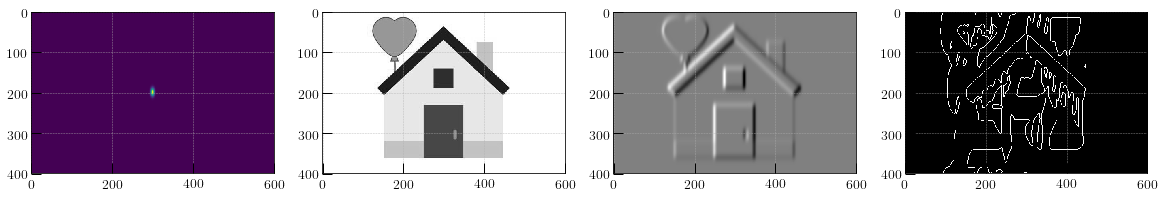

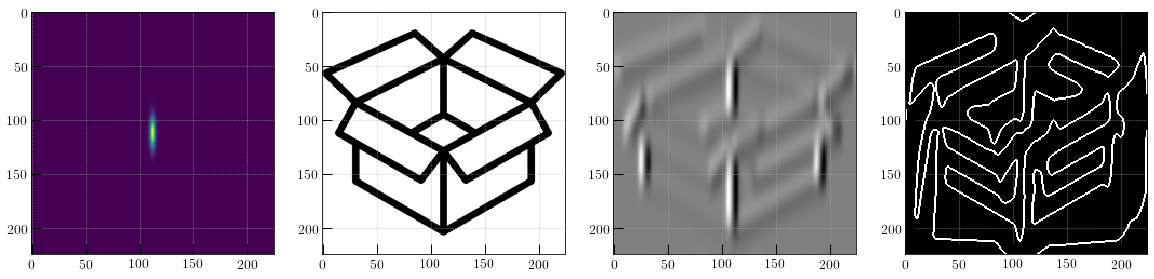

In [65]:
for img_filename in glob.glob('*.png'):
    border_theta(
        img_filename=img_filename,
        factor_x=factor_x, 
        factor_y=factor_y, 
        theta=0,
        sigma_0 = sigma_0,
        DoG =  True
    )